In [16]:
import learn2learn as l2l
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from sklearn import tree

from indtree.gentree_utils import load_data
from indtree.tree_dataset_generation import generate_train_val_test_datasets_from_separate_rf
from indtree.metamodel import MetaModel, TreeDataModule
from indtree.torch_dataset import TreeFitting
from indtree.siren_multioutput import SirenSingleBranch
from indtree.tree_dataset_generation import direct_encodings_to_trees

In [31]:
%%time
X_train, X_val, X_test, y_train, y_val, y_test = load_data("wine")
dict_data = {
    "X_train": X_train,
    "X_val": X_val,
    "X_test": X_test,
    "y_train": y_train,
    "y_val": y_val,
    "y_test": y_test,
}

(
    X_tree_feat_train,
    X_class_train,
    X_thresh_train,
    rf_train,
    X_tree_feat_val,
    X_class_val,
    X_thresh_val,
    rf_val,
    X_tree_feat_test,
    X_class_test,
    X_thresh_test,
    rf_test,
) = generate_train_val_test_datasets_from_separate_rf(
    X=X_train,
    y=y_train,
    random_state=42,
    max_depth=3,
    n_train=2,
)

print(rf_train.score(X_train, y_train), rf_val.score(X_val, y_val), rf_test.score(X_test, y_test))

COORDS_TYPE = "binary"

meta_dataloader_train = []
for i in range(X_tree_feat_train.shape[0]):
    meta_dataloader_train.append(
        TreeFitting(
            X_tree_feat_train[i],
            X_thresh_train[i],
            X_class_train[i],
            coords_type=COORDS_TYPE,
            normalize=True,
        )
    )
    
n_coords = meta_dataloader_train[0].coords.shape[-1]

meta_dataloader_val = []
for i in range(X_tree_feat_val.shape[0]):
    meta_dataloader_val.append(
        TreeFitting(
            X_tree_feat_val[i],
            X_thresh_val[i],
            X_class_test[i],
            coords_type=COORDS_TYPE,
            normalize=True,
        )
    )

meta_dataloader_test = []
for i in range(X_tree_feat_test.shape[0]):
    meta_dataloader_test.append(
        TreeFitting(
            X_tree_feat_test[i],
            X_thresh_test[i],
            X_class_test[i],
            coords_type=COORDS_TYPE,
            normalize=True,
        )
    )

0.5170290552241678 0.5430769230769231 0.5276923076923077
CPU times: user 443 ms, sys: 16.8 ms, total: 460 ms
Wall time: 463 ms


In [32]:
metamodel = l2l.algorithms.MAML

In [33]:
model = SirenSingleBranch(
    in_features=n_coords,
    hidden_features=32,
    hidden_layers=1,
    out_features=X_train.shape[1],
    out_classes=len(np.unique(y_train)),
)

In [34]:
print(X_class_train.shape, X_tree_feat_train.shape, X_thresh_train.shape, X_class_val.shape, X_tree_feat_val.shape, X_thresh_val.shape, X_class_test.shape, X_tree_feat_test.shape, X_thresh_test.shape)


(2, 15, 7) (2, 15, 11) (2, 15, 1) (100, 15, 7) (100, 15, 11) (100, 15, 1) (100, 15, 7) (100, 15, 11) (100, 15, 1)


In [35]:
coords_, onehot_feat_, onehot_thresh_, onehot_class_ = next(iter(meta_dataloader_test[0]))
coords_.shape, onehot_feat_.shape, onehot_thresh_.shape, onehot_class_.shape

(torch.Size([15, 4]),
 torch.Size([15, 11]),
 torch.Size([15, 1]),
 torch.Size([15, 7]))

In [47]:
# Initialize the LightningModule
lightning_model = MetaModel(
    model=model,
    metamodel=metamodel,
    metamodel_params=dict(
        lr=1e-3,
        first_order=False,
    ),
    optimizer_params=dict(
        lr=1e-5,
    ),
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    rf_val=rf_val,
    tree_log_params=dict(
                on_step=False,
                on_epoch=True,
                prog_bar=False,
                logger=True,
            ),
    weight_feat=1,
    weight_thresh=1,
    weight_class=1,
    rf_log_freq=1,
)

# Initialize the DataModule
data_module = TreeDataModule(
    meta_dataloader_train,
    meta_dataloader_val,
    meta_dataloader_test,
    batch_size=1024,
)



In [48]:
dir(metamodel)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_call_impl',
 '_compiled_call_impl',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_load_from_state_dict',
 '_maybe_warn_non_full_backward_hook',
 '_named_members',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_version',
 '_wrapped_call_impl',
 'adapt',
 'add_module',
 'apply',
 'bfloat16',
 'buffers',
 'call_super_init',
 'children',
 'clone',
 'compile',
 'cpu',
 'cuda',
 'double',
 'dump

In [49]:
trainer = pl.Trainer(
    max_epochs=2000,
    accelerator='cpu',
)
trainer.fit(lightning_model, datamodule=data_module)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/francesco/miniforge3/envs/inrtree2/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/francesco/miniforge3/envs/inrtree2/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SirenSingleBranch | 4.3 K  | train
1 | loss_fn_feat   | CrossEntropyLoss  | 0      | train
2 | loss_fn_class  | CrossEntropyLoss  | 0      | train
3 | loss_fn_thresh | MSELoss           | 0      | train
4 | metamodel_     | MAML              | 4.3 K  | train
-------------------------------------------------------------
4.3 K     Trainable

Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 33.60it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 28.37it/s, v_num=3]


## Reconstructing the Tree

In [50]:
i = 0
list_train_loader = list(meta_dataloader_train)
coords_, onehot_feat_, onehot_class_, onehot_thresh_ = list_train_loader[i].coords.unsqueeze(0), list_train_loader[i].onehot_feat.unsqueeze(0), list_train_loader[i].onehot_thresh.unsqueeze(0), list_train_loader[i].onehot_class.unsqueeze(0)

In [51]:
feat_out, thresh_out, class_out = lightning_model(coords_, onehot_feat_, onehot_thresh_, onehot_class_)
feat_out.shape, thresh_out.shape, class_out.shape

(torch.Size([1, 15, 11]), torch.Size([1, 15, 1]), torch.Size([1, 15, 7]))

In [52]:

orig_tree = direct_encodings_to_trees(onehot_feat_.numpy(), onehot_class_.numpy(), onehot_thresh_.numpy())
recon_tree = direct_encodings_to_trees(feat_out.detach().numpy(), class_out.detach().numpy(), thresh_out.detach().numpy())

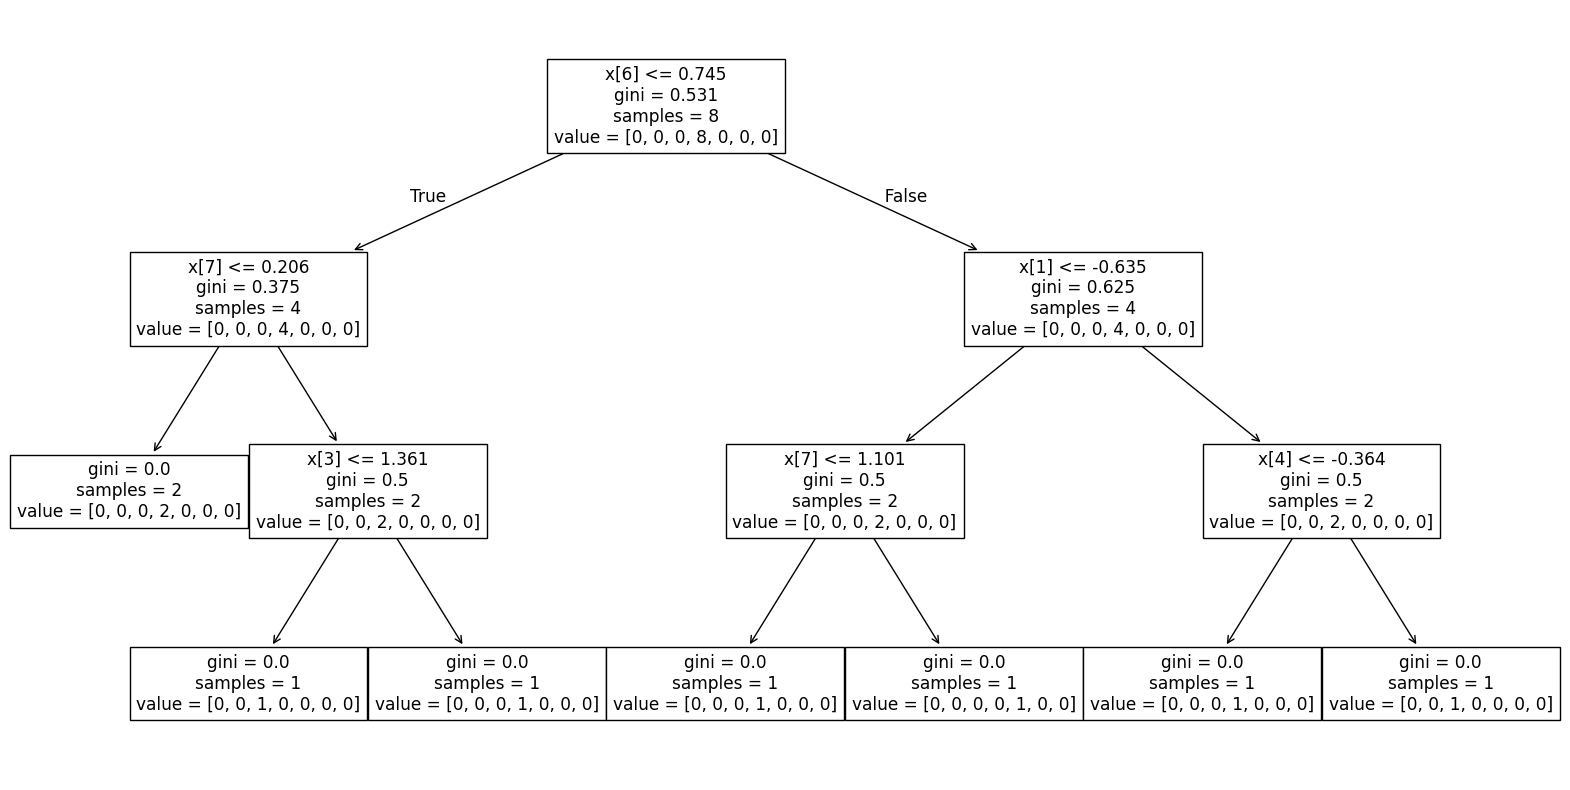

In [53]:
plt.figure(figsize=(20, 10))
tree.plot_tree(orig_tree[0])
plt.show()

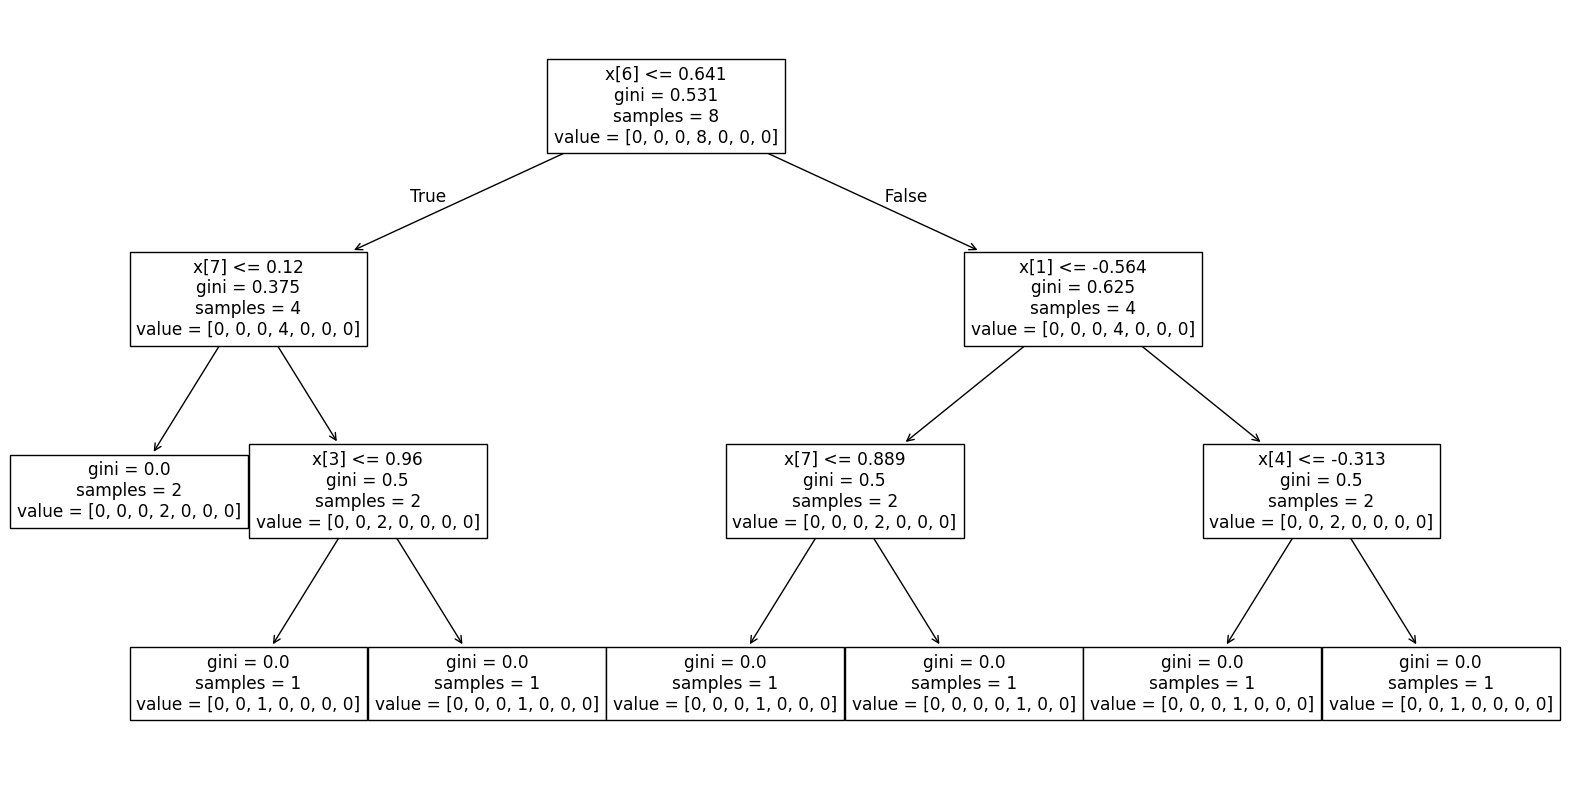

In [54]:
plt.figure(figsize=(20, 10))
tree.plot_tree(recon_tree[0])
plt.show()